#**1) Importing the necessary libraries**

In [ ]:
#Vibhuvan
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import cv2
from google.colab.patches import cv2_imshow

#**2) Image Preprocessing**

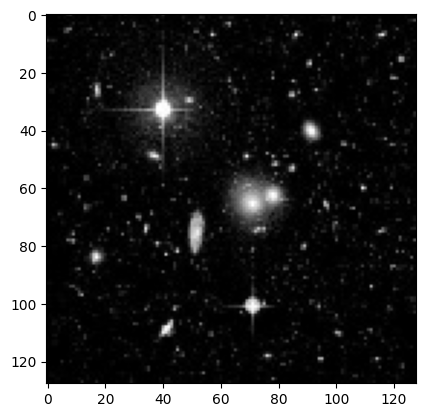

In [ ]:
#Vibhuvan
# Showing the clean image 
img1 = Image.open("Reference_img1.jpg").convert('L')
I_trail = np.array(img1, dtype=np.float32)
plt.imshow(I_trail, cmap="gray")

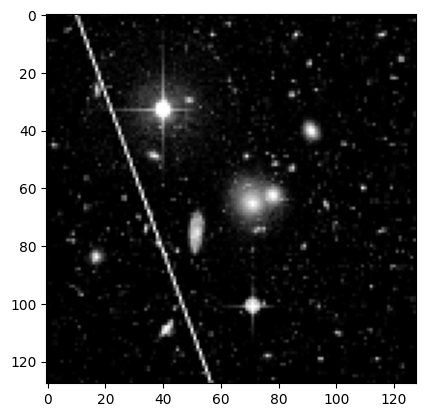

In [ ]:
#Vibhuvan
# Repeating the same steps for image1
img1 = Image.open("img1_trail.png").convert('L')
I_trail = np.array(img1, dtype=np.float32)
plt.imshow(I_trail, cmap="gray")

True

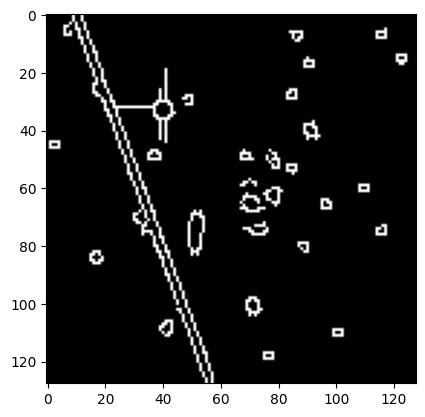

In [ ]:
#Keerthan
# We are applying Gaussian Blur to the image before applying Canny edge map to smooth the noise
blur_img = cv2.GaussianBlur(I_trail, (5, 5), 0)
I_trail_blur = np.uint8(blur_img) 
# Here, we apply Canny edge detector to our image since our Hough function takes Canny edge maps as input
canny_img = cv2.Canny(I_trail_blur, 100, 200)
plt.imshow(canny_img, cmap="gray")
cv2.imwrite('canny_image1.jpg', canny_img)

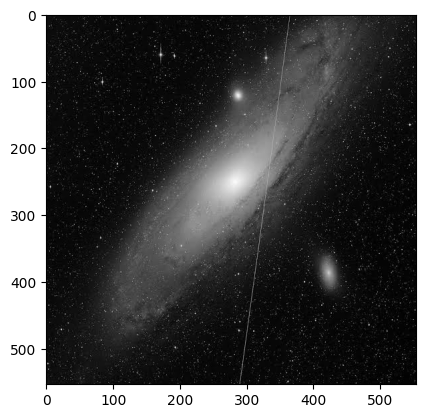

In [ ]:
#Vibhuvan
# Repeating the same steps for image2
img2 = Image.open("image2.jpg").convert('L')
I_trail_img2 = np.array(img2, dtype=np.float32)
plt.imshow(I_trail_img2, cmap="gray")

True

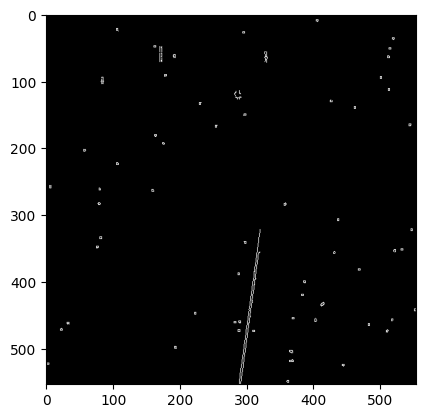

In [ ]:
#Keerthan
blur_img2 = cv2.GaussianBlur(I_trail_img2, (5, 5), 0)
I_trail_img2_blur = np.uint8(blur_img2)
canny_img2 = cv2.Canny(I_trail_img2_blur, 100, 200)
plt.imshow(canny_img2, cmap="gray")
cv2.imwrite('canny_img2.jpg', canny_img2)

#**3) Hough function to detect straight lines**

In [ ]:
#Vibhuvan
def hough_line(img, angle_step=1, lines_are_white=True, value_threshold=5):
    """
    Hough transform for lines
    Input:
    img - 2D binary image with nonzeros representing edges
    angle_step - Spacing between angles to use every n-th angle
                 between -90 and 90 degrees. Default step is 1.
    lines_are_white - boolean indicating whether lines to be detected are white
    value_threshold - Pixel values above or below the value_threshold are edges
    """
    # Rho and Theta ranges
    thetas = np.deg2rad(np.arange(-90.0, 90.0, angle_step))
    width, height = img.shape
    diag_len = int(round(np.sqrt(width * width + height * height)))
    rhos = np.linspace(-diag_len, diag_len, diag_len * 2)

    # Cache some resuable values
    cos_t = np.cos(thetas)
    sin_t = np.sin(thetas)
    num_thetas = len(thetas)

    # Hough accumulator array of theta vs rho
    accumulator = np.zeros((2 * diag_len, num_thetas), dtype=np.uint8)
    # (row, col) indexes to edges
    are_edges = img > value_threshold if lines_are_white else img < value_threshold
    y_idxs, x_idxs = np.nonzero(are_edges)

    # Vote in the hough accumulator
    for i in range(len(x_idxs)):
        x = x_idxs[i]
        y = y_idxs[i]

        for t_idx in range(num_thetas):
            # Calculate rho. diag_len is added for a positive index
            rho = diag_len + int(round(x * cos_t[t_idx] + y * sin_t[t_idx]))
            accumulator[rho, t_idx] += 1
            
    """
    Returns:
    accumulator - 2D array of the hough transform accumulator
    theta - array of angles used in computation, in radians.
    rhos - array of rho values. Max size is 2 times the diagonal
           distance of the input image.
    """

    return accumulator, thetas, rhos

#**4) Printing the (r, theta) parameters of the strongest line detected**

In [ ]:
#Vibhuvan
accumulator, thetas, rhos = hough_line(canny_img)

# Find maximum value in accumulator array
max_value_idx = np.argmax(accumulator)
max_rho_idx, max_theta_idx = np.unravel_index(max_value_idx, accumulator.shape)
max_rho, max_theta = rhos[max_rho_idx], thetas[max_theta_idx]

# Print detected line
print(f"Detected line: rho={max_rho}, theta={np.rad2deg(max_theta)}")

Detected line: rho=11.53185595567868, theta=-20.0


#**5) Showing the detected line**

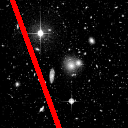

True

In [ ]:
#Vibhuvan
x1 = 0
y1 = int((max_rho - x1 * np.cos(max_theta)) / np.sin(max_theta))
x2 = I_trail.shape[1]
y2 = int((max_rho - x2 * np.cos(max_theta)) / np.sin(max_theta))

# Draw line on image
img_with_line = cv2.cvtColor(I_trail, cv2.COLOR_GRAY2BGR)
cv2.line(img_with_line, (x1, y1), (x2, y2), (0, 0, 255), 4)


cv2_imshow(img_with_line)
cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.imwrite('img1_with_linedetected.jpg', img_with_line)

#**6) Showing the final image with detected line removed**

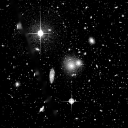

True

In [ ]:
#Vibhuvan
mask = np.uint8(np.zeros_like(I_trail))
cv2.line(mask, (x1, y1), (x2, y2), 255, 5)

# Apply inpainting algorithm to remove line
img_without_line = cv2.inpaint(I_trail, mask, 3, cv2.INPAINT_NS)


# Show image with detected line removed
cv2_imshow(img_without_line)
cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.imwrite('img1_line_removed.jpg', img_without_line)

#**6) SSIM**

In [ ]:
#Keerthan
def luminance_similarity(I,J,window):
    C1 = (0.01*255)**2
    if I.shape!= J.shape:
        print("both the images are not of same shape!")
        return None
    
    N,M = I.shape
    r,c = window.shape
    p,q = r//2, c//2
    
    I_padded = np.zeros((N + r, M + c)).astype(np.float64)
    I_padded[p:N+p,q:M+q] = I
    J_padded = np.zeros((N + r, M + c)).astype(np.float64)
    J_padded[p:N+p,q:M+q] = J
    
    mu_I = np.zeros_like(I,dtype=np.float64)
    mu_J = np.zeros_like(J,dtype=np.float64)
    
    LSM = np.zeros_like(I, dtype=np.float64)
    
    for i in range(N):
        for j in range(M):
            windowed_set_1 = I_padded[i:i+r,j+c]
            windowed_set_2 = J_padded[i:i+r,j+c]
            
            mu_I[i,j] = np.sum(np.multiply(windowed_set_1, window))
            mu_J[i,j] = np.sum(np.multiply(windowed_set_2, window))
            
            LSM[i,j] = (2*mu_I[i,j]*mu_J[i,j] + C1)/(mu_I[i,j]**2 + mu_J[i,j]**2 + C1)
            
    return LSM, mu_I, mu_J

In [ ]:
#Keerthan
def constrast_similarity(I,J,mu_I,mu_J,window):
    C2 = (0.03*255) ** 2
    
    if I.shape!= J.shape:
        print("both the images are not of same shape!")
        return None
    
    N,M = I.shape
    r,c = window.shape
    p,q = r//2, c//2
    
    I_padded = np.zeros((N + r, M + c)).astype(np.float64)
    I_padded[p:N+p,q:M+q] = I
    J_padded = np.zeros((N + r, M + c)).astype(np.float64)
    J_padded[p:N+p,q:M+q] = J
    
    mu_I_padded = np.zeros((N + r, M + c)).astype(np.float64)
    mu_I_padded[p:N+p,q:M+q] = mu_I
    mu_J_padded = np.zeros((N + r, M + c)).astype(np.float64)
    mu_J_padded[p:N+p,q:M+q] = mu_I
    
    std_I = np.zeros_like(I,dtype=np.float64)
    std_J = np.zeros_like(J,dtype=np.float64)
    
    CSM = np.zeros_like(I, dtype=np.float64)
    
    for i in range(N):
        for j in range(M):
            windowed_set_1 = I_padded[i:i+r,j+c] - mu_I_padded[i:i+r,j+c]
            windowed_set_2 = J_padded[i:i+r,j+c] - mu_J_padded[i:i+r,j+c]
            
            std_I[i,j] = np.sqrt(np.sum(np.multiply(np.square(windowed_set_1), window)))
            std_J[i,j] = np.sqrt(np.sum(np.multiply(np.square(windowed_set_2), window)))
            
            CSM[i,j] = (2*std_I[i,j]*std_J[i,j] + C2)/(std_I[i,j]**2 + std_J[i,j]**2 + C2)
    return CSM, std_I, std_J

In [ ]:
#Keerthan
def structural_similarity(I,J,mu_I,mu_J,std_I,std_J,window):
    C3 = ((0.03*255) ** 2)/2
    
    if I.shape!= J.shape:
        print("both the images are not of same shape!")
        return None
    
    N,M = I.shape
    r,c = window.shape
    p,q = r//2, c//2
    
    I_padded = np.zeros((N + r, M + c)).astype(np.float64)
    I_padded[p:N+p,q:M+q] = I
    J_padded = np.zeros((N + r, M + c)).astype(np.float64)
    J_padded[p:N+p,q:M+q] = J
    
    mu_I_padded = np.zeros((N + r, M + c)).astype(np.float64)
    mu_I_padded[p:N+p,q:M+q] = mu_I
    mu_J_padded = np.zeros((N + r, M + c)).astype(np.float64)
    mu_J_padded[p:N+p,q:M+q] = mu_I
    
    cv_12 = np.zeros_like(I, dtype=np.float64)
    SSM = np.zeros_like(I, dtype=np.float64)
    
    for i in range(N):
        for j in range(M):
            windowed_set_1 = I_padded[i:i+r,j+c] - mu_I_padded[i:i+r,j+c]
            windowed_set_2 = J_padded[i:i+r,j+c] - mu_J_padded[i:i+r,j+c]
            
            cv_12[i,j] = np.sum(np.multiply(np.multiply(windowed_set_1,windowed_set_2), window))
            SSM[i,j] = (cv_12[i,j] + C3)/(std_I[i,j]*std_J[i,j] + C3)
    return SSM,cv_12

In [ ]:
#Keerthan
def SSIM_index(I,J,window):
    LSM, mu_I, mu_J = luminance_similarity(I,J,window)
    CSM, std_I, std_J = constrast_similarity(I,J, mu_I, mu_J,window)
    SSM, _ = structural_similarity(I,J,mu_I,mu_J,std_I,std_J,window)
    
    SSIM_map =np.multiply(np.multiply(LSM,CSM),SSM)
    MSSIM = np.mean(SSIM_map)
    return SSIM_map, MSSIM

In [ ]:
#Keerthan
def get_gaussian_window(size, sig=2):
    k = size//2

    x, y = np.mgrid[-k: k + 1, -k: k + 1]
    gauss_window = np.exp(-(x ** 2 + y ** 2) / (2 * sig ** 2))
        
    gauss_window[gauss_window < np.finfo(gauss_window.dtype).eps*gauss_window.max() ] = 0
    sum_window = np.sum(gauss_window)
    if sum_window != 0:
        gauss_window /= sum_window
    return gauss_window

gaussian_window = get_gaussian_window(size=5, sig=2)

True

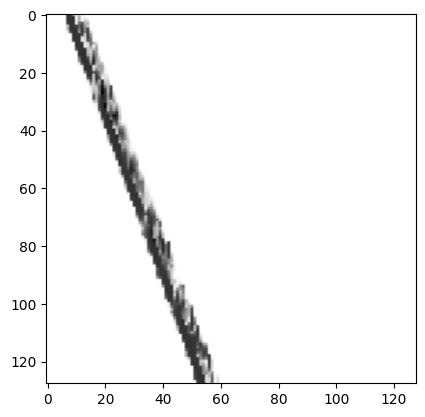

In [ ]:
#Keerthan
SSIM_map, MSSIM = SSIM_index(I_trail,img_without_line, gaussian_window)
plt.imshow(SSIM_map, cmap="gray")
cv2.imwrite('SSIM_img1.jpg', SSIM_map)

In [ ]:
print(MSSIM)

0.9584051898865598


In [ ]:
#Vibhuvan
#Repeating the same for image 2
accumulator, thetas, rhos = hough_line(canny_img2)

# Find maximum value in accumulator array
max_value_idx = np.argmax(accumulator)
max_rho_idx, max_theta_idx = np.unravel_index(max_value_idx, accumulator.shape)
max_rho, max_theta = rhos[max_rho_idx], thetas[max_theta_idx]

# Print detected line
print(f"Detected line: rho={max_rho}, theta={np.rad2deg(max_theta)}")

Detected line: rho=362.7316293929712, theta=8.0


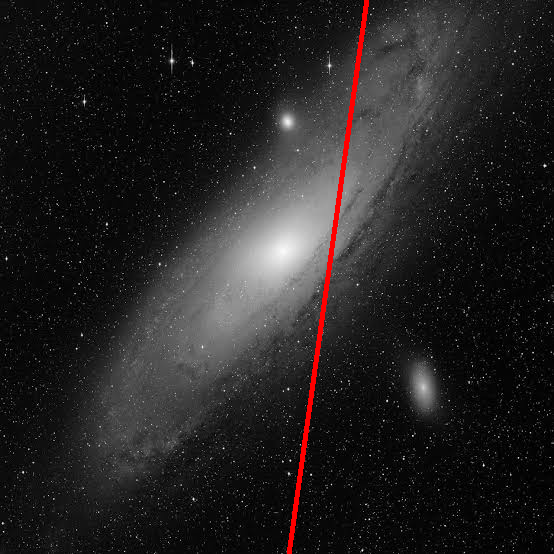

True

In [ ]:
#Vibhuvan
x1 = 0
y1 = int((max_rho - x1 * np.cos(max_theta)) / np.sin(max_theta))
x2 = I_trail_img2.shape[1]
y2 = int((max_rho - x2 * np.cos(max_theta)) / np.sin(max_theta))

# Draw line on image
img_with_line = cv2.cvtColor(I_trail_img2, cv2.COLOR_GRAY2BGR)
cv2.line(img_with_line, (x1, y1), (x2, y2), (0, 0, 255), 4)


cv2_imshow(img_with_line)
cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.imwrite('image2_withline_detected.jpg', img_with_line)

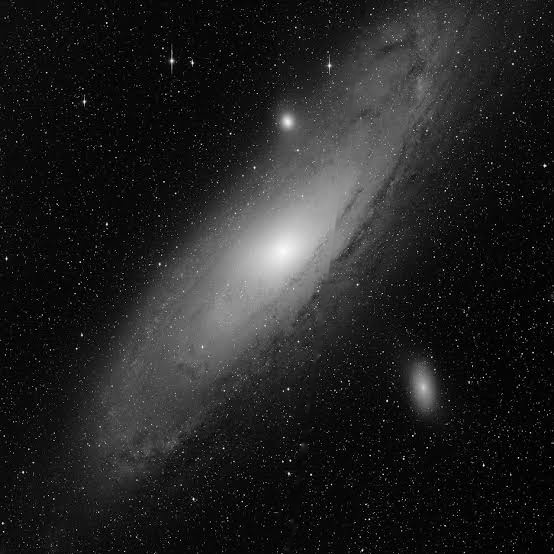

True

In [ ]:
#Vibhuvan
mask = np.uint8(np.zeros_like(I_trail_img2))
cv2.line(mask, (x1, y1), (x2, y2), 255, 5)

# Apply inpainting algorithm to remove line
img_without_line = cv2.inpaint(I_trail_img2, mask, 3, cv2.INPAINT_NS)


# Show image with detected line removed
cv2_imshow(img_without_line)
cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.imwrite('image2_without_detectedline.jpg', img_without_line)